In [120]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_validate

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [121]:
data = pd.read_csv('model_data.csv', index_col='PID')
data.shape

(2579, 23)

#### Independent Variable (y)

In [122]:
y = data.SalePrice.copy()
data.drop('SalePrice', axis=1, inplace=True)

#### Choose Dependents (Use Sector or Neighborhood) (Use ALLSF, or split columns)

In [123]:
data.columns

Index(['MSSubClass', 'GarageCars', 'GarageType', 'BsmtQual', 'Foundation',
       'PavedDrive', 'TotalBsmtSF', 'AllBathBsmt', 'AllBathAbv',
       'TotRmsAbvGrd', 'Fireplaces', 'HeatingQC', 'Neighborhood', 'Sector',
       'YearBuilt', 'OverallQual', 'LotFrontage', '1stFlrSF', '2ndFlrSF',
       'GarageArea', 'PorchArea', 'ALLSF'],
      dtype='object')

* Sectors & ALLSF

In [124]:
data_1 = data.drop(['Neighborhood','1stFlrSF', '2ndFlrSF', 'GarageArea', 'PorchArea', 'TotalBsmtSF'],axis=1)

* Sectors & Split SF

In [125]:
data_2 = data.drop(['Neighborhood','ALLSF'],axis=1)

* Neighborhood & ALLSF

In [126]:
data_3 = data.drop(['Sector','1stFlrSF', '2ndFlrSF', 'GarageArea', 'PorchArea', 'TotalBsmtSF'],axis=1)

* Neighborhood & Split SF

In [127]:
data_4 = data.drop(['Sector','ALLSF'],axis=1)

## 📉 Multiple Regression

#### Data_1

In [130]:
lasso = Lasso(max_iter=10000)

data_dum = pd.get_dummies(data_1, drop_first=True)
scores = cross_validate(lasso, data_dum, np.log10(y), cv=4)
np.mean(scores['test_score'])

0.6441628927347836

#### Data_2

In [132]:
data_dum = pd.get_dummies(data_2, drop_first=True)
scores = cross_validate(lasso, data_dum, np.log10(y), cv=4)
np.mean(scores['test_score'])

0.6435204263023244

#### Data_3

In [133]:
data_dum = pd.get_dummies(data_3, drop_first=True)
scores = cross_validate(lasso, data_dum, np.log10(y), cv=4)
np.mean(scores['test_score'])

0.6441628927347836

#### Data_4

In [134]:
data_dum = pd.get_dummies(data_4, drop_first=True)
scores = cross_validate(lasso, data_dum, np.log10(y), cv=4)
np.mean(scores['test_score'])

0.6435204263023244

In [144]:
X_train, X_test, y_train, y_test = train_test_split(data_dum, y, test_size=0.3)

In [155]:
lasso.fit(X_train,np.log10(y_train))
lasso.score(X_test,np.log10(y_test))

0.8818029573424763

In [158]:
lasso.set_params(normalize=True, random_state=44)
lasso.get_params()

{'alpha': 0.003,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 10000,
 'normalize': True,
 'positive': False,
 'precompute': False,
 'random_state': 44,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [159]:
#try different alphas
alphas = np.linspace(0.00001,0.003,400)
coefs_lasso = []
R2_train = []
R2_test = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, np.log10(y_train))
    coefs_lasso.append(lasso.coef_)
    R2_train.append(lasso.score(X_train, np.log10(y_train)))
    R2_test.append(lasso.score(X_test, np.log10(y_test)))

In [160]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train.columns)
R2_lasso = pd.DataFrame({'train': R2_train,'test':R2_test}, index = alphas)
coefs_lasso.head(2)

,GarageCars,TotalBsmtSF,AllBathBsmt,AllBathAbv,TotRmsAbvGrd,Fireplaces,YearBuilt,OverallQual,LotFrontage,1stFlrSF,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0.000010,0.009306,0.000037,0.030325,0.003402,0.000000,0.016206,0.000634,0.033531,0.00005,0.000118,...,0.017570,0.039676,-0.016238,-0.016366,-0.0,-0.010207,0.026810,0.052919,0.014535,0.025948
0.000017,0.008872,0.000037,0.030081,0.003380,0.000039,0.016166,0.000684,0.034149,0.00005,0.000118,...,0.015267,0.035325,-0.014692,-0.012795,-0.0,-0.009512,0.023021,0.046989,0.011224,0.021205


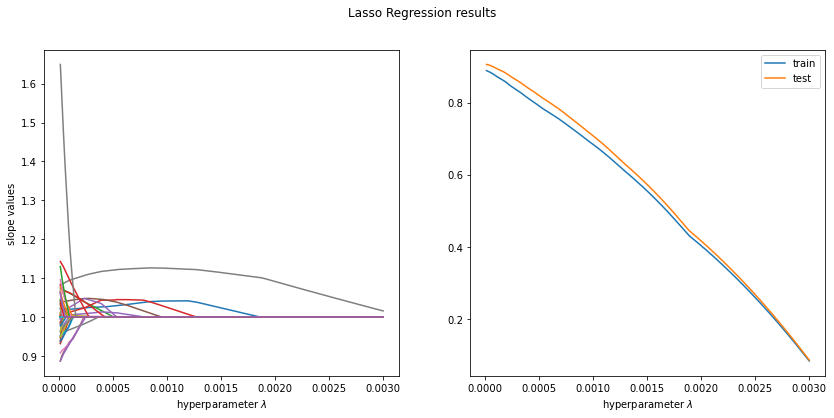

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Lasso Regression results')

for feat in coefs_lasso.columns:
    ax1.plot(coefs_lasso.index, 10**coefs_lasso[feat]) 
ax1.set_xlabel(r'hyperparameter $\lambda$')
ax1.set_ylabel(r'slope values')
#ax1.legend(loc=1)
for each in R2_lasso.columns:
    ax2.plot(R2_lasso.index, R2_lasso[each], label=each)
ax2.set_xlabel(r'hyperparameter $\lambda$')
ax2.legend(loc=1)

## 🌲 Prepare for RandomForest

In [163]:
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder

In [164]:
data_le = data_4.copy()
data_le.columns

Index(['MSSubClass', 'GarageCars', 'GarageType', 'BsmtQual', 'Foundation',
       'PavedDrive', 'TotalBsmtSF', 'AllBathBsmt', 'AllBathAbv',
       'TotRmsAbvGrd', 'Fireplaces', 'HeatingQC', 'Neighborhood', 'YearBuilt',
       'OverallQual', 'LotFrontage', '1stFlrSF', '2ndFlrSF', 'GarageArea',
       'PorchArea'],
      dtype='object')

In [165]:
# Use LabelEncoder on Categorical features
le = LabelEncoder()
data_le.MSSubClass = le.fit_transform(data.MSSubClass)
data_le.GarageType = le.fit_transform(data.GarageType)
data_le.Foundation = le.fit_transform(data.Foundation)
data_le.PavedDrive = le.fit_transform(data.PavedDrive)
data_le.Neighborhood = le.fit_transform(data.Neighborhood)
# Manually Encode Ordinal features
data_le.BsmtQual = data_le.BsmtQual.replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5,np.NaN:0})
data_le.HeatingQC = data_le.HeatingQC.replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

In [166]:
X_train, X_test, y_train, y_test = train_test_split(data_le, y, test_size=0.25)

In [167]:
forest = ensemble.RandomForestRegressor()
forest.set_params(n_estimators=50, random_state=42, max_features=10)
forest.fit(X_train, y_train)
print("The training r2: %.5f" %(forest.score(X_train, y_train)))
print("The test     r2: %.5f" %(forest.score(X_test, y_test)))

The training r2: 0.98415
The test     r2: 0.85991


### Some Overfit?

In [168]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 10,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [169]:
from sklearn.model_selection import GridSearchCV

In [170]:
grid_para_forest = [{
    "max_features":np.arange(8,15,1),
    "max_depth": np.linspace(start=6, stop=30, num=13, dtype=int)}]
gs_forest = GridSearchCV(forest, grid_para_forest, scoring='r2', cv=4, n_jobs=-1)
%time gs_forest.fit(X_train, y_train)

Wall time: 24.7 s


GridSearchCV(cv=4,
             estimator=RandomForestRegressor(max_features=10, n_estimators=50,
                                             random_state=42),
             n_jobs=-1,
             param_grid=[{'max_depth': array([ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                          'max_features': array([ 8,  9, 10, 11, 12, 13, 14])}],
             scoring='r2')

In [171]:
gs_forest.best_params_

{'max_depth': 26, 'max_features': 8}

In [172]:
print("The training r2: %.5f" % (gs_forest.score(X_train, y_train)))
print("The test     r2: %.5f" % (gs_forest.score(X_test, y_test)))

The training r2: 0.98341
The test     r2: 0.85717


In [173]:
pd.DataFrame({'Feat':X_train.columns,'Importance':gs_forest.best_estimator_.feature_importances_}).\
sort_values(by='Importance', ascending=False)

,Feat,Importance
14,OverallQual,0.282800
1,GarageCars,0.127154
6,TotalBsmtSF,0.110044
16,1stFlrSF,0.073829
13,YearBuilt,0.070696
18,GarageArea,0.067861
8,AllBathAbv,0.051542
3,BsmtQual,0.046765
17,2ndFlrSF,0.034919
10,Fireplaces,0.025677


## 🚀 Boosting

In [174]:
from sklearn.ensemble import GradientBoostingRegressor

In [175]:
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
gbm.score(X_test, y_test)

0.8609993238128317

In [176]:
gbm.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [91]:
grid_para_boost = [{
    "learning_rate":[0.1,0.25,0.5,1],
    "max_depth": np.linspace(start=6, stop=30, num=13, dtype=int)}]
gs_boost = GridSearchCV(gbm, grid_para_boost, scoring='r2', cv=5, n_jobs=-1)
%time gs_boost.fit(X_train, y_train)

Wall time: 1min 15s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.1, 0.25, 0.5, 1],
                          'max_depth': array([ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
             scoring='r2')

In [92]:
gs_boost.best_params_

{'learning_rate': 0.1, 'max_depth': 6}

In [93]:
print("The training r2: %.5f" % (gs_boost.score(X_train, y_train)))
print("The test     r2: %.5f" % (gs_boost.score(X_test, y_test)))

The training r2: 0.98753
The test     r2: 0.87752
